<a href="https://colab.research.google.com/github/akhilmw/ImageProcessingModel/blob/main/dehazingfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arkgree","key":"caaec281281c000fe48a18af766f9723"}\n'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# https://www.kaggle.com/balraj98/synthetic-objective-testing-set-sots-reside
!kaggle datasets download -d balraj98/synthetic-objective-testing-set-sots-reside


 96% 400M/415M [00:04<00:00, 117MB/s] 
100% 415M/415M [00:04<00:00, 90.0MB/s]


In [ ]:
!unzip synthetic-objective-testing-set-sots-reside.zip 
!rm synthetic-objective-testing-set-sots-reside.zip

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 8.8MB/s 


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Input,Concatenate,LeakyReLU,Add,Conv2DTranspose
from tensorflow.keras.initializers import TruncatedNormal
import tensorflow_addons as tfa
from skimage.transform import resize
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

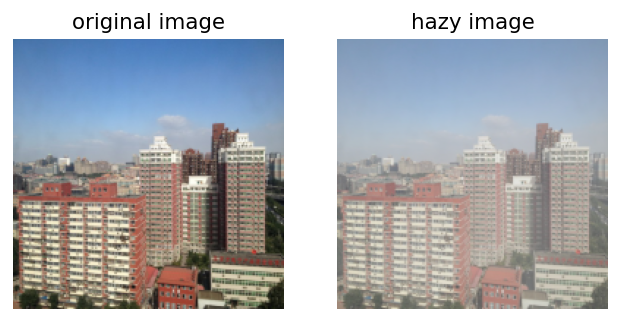

In [ ]:
im = plt.imread('/content/outdoor/clear/0001.png')
M = 185
im = resize(im,(M ,M ))
im_hazy = plt.imread('/content/outdoor/hazy/0001_0.8_0.2.jpg')
im_hazy = resize(im_hazy,(M ,M))
plt.figure(dpi=128)
plt.subplot(121)
plt.imshow(im)
plt.axis('off')
plt.title('original image')
plt.subplot(122)
plt.imshow(im_hazy)
plt.title('hazy image')
plt.axis('off')
plt.show()

In [ ]:
# df = pd.read_csv('/content/metadata_indoor.csv')
# nrow,ncol = df.shape
# print(f'There are {nrow} rows and {ncol} columns')
# df.head()

In [ ]:
# reverse parametric rectified linear unit 
import tensorflow as tf
def rprelu(x):
  leak = tf.Variable(0.1)
  f1 = 0.5 * (1 + leak)
  f2 = 0.5 * (1 - leak)
  return f1 * tf.abs(x) - f2 * x


# transformation component
def resnet(x1):
  x2 = Conv2D(filters=64,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (x1)
  x2 = tfa.layers.GroupNormalization() (x2)
  x2 = rprelu(x2) 

  x3 = Conv2D(filters=64,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (x2)
  x3 = tfa.layers.GroupNormalization() (x3)
  x3 = rprelu(x3) 

  x4 = Conv2D(filters=128,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (x3)
  x4 = tfa.layers.GroupNormalization() (x4)
  x4 = rprelu(x4) 

  x5 = Add()([x1,x4])
  x5 = rprelu(x5) 
  return x5
def clip(x):
    Max = tf.constant([255.0])
    return tf.minimum(x, Max)

In [ ]:
initializer = TruncatedNormal(mean=0., stddev=1.)

inputx = Input(shape=im.shape)
conv_3k = Conv2D(filters=64,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (inputx)
conv_5k = Conv2D(filters=32,kernel_size=5,strides=1, padding='SAME', kernel_initializer=initializer) (inputx)
conv_7k = Conv2D(filters=32,kernel_size=7,strides=1, padding='SAME', kernel_initializer=initializer) (inputx)

conv1 = Concatenate(axis=3)([conv_3k,conv_5k,conv_7k])
conv1 = tfa.layers.GroupNormalization() (conv1)
conv1 = LeakyReLU(alpha=0.2) (conv1)

conv2 = Conv2D(filters=64,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (conv1)
conv2 = tfa.layers.GroupNormalization() (conv2)
conv2 = LeakyReLU(alpha=0.2) (conv2)

conv3 = Conv2D(filters=128,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (conv2)
conv3 = tfa.layers.GroupNormalization() (conv3)
conv3 = LeakyReLU(alpha=0.2) (conv3)

conv4 = resnet(conv3)
conv4 = resnet(conv4)
conv4 = resnet(conv4)
conv4 = resnet(conv4)

convt1 = Conv2DTranspose(filters=128,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (conv4)
convt1 = tfa.layers.GroupNormalization() (convt1)
convt1 = rprelu(convt1)
convt2 = Concatenate(axis=3)([conv3,convt1])


convt3 = Conv2DTranspose(filters=256,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (convt2)
convt3 = tfa.layers.GroupNormalization() (convt3)
convt3 = LeakyReLU(alpha=0.2) (convt3)

convt4 = Conv2DTranspose(filters=128,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (convt3)
convt4 = tfa.layers.GroupNormalization() (convt4)
convt4 = rprelu(convt4)
convt5 = Concatenate(axis=3)([conv2,convt4])

convt6 = Conv2DTranspose(filters=256,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (convt5)
convt6 = tfa.layers.GroupNormalization() (convt6)
convt6 = LeakyReLU(alpha=0.2) (convt6)

convt7 = Conv2DTranspose(filters=128,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (convt6)
convt7 = tfa.layers.GroupNormalization() (convt7)
convt7 = rprelu(convt7)
convt8 = Concatenate(axis=3)([conv1,convt7])


convt9 = Conv2DTranspose(filters=256,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (convt8)
convt9 = tfa.layers.GroupNormalization() (convt9)
convt9 = LeakyReLU(alpha=0.2) (convt9)

conv10 = Conv2D(filters=3,kernel_size=3,strides=1, padding='SAME', kernel_initializer=initializer) (convt9)

y1 = Add()([conv10,inputx])
y1 = LeakyReLU(alpha=0.2) (y1)
y1 = clip(y1)

model =Model(inputs=inputx,outputs=y1)

model.compile(optimizer=SGD(learning_rate=0.0001,momentum=0.4),loss='mse',metrics=['accuracy'])

(1, 185, 185, 3)


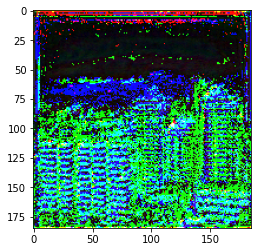

In [ ]:
inp = np.expand_dims(im,axis=0)
out = model.predict(inp)
print(out.shape)
out=np.uint8(np.squeeze(out[0,:,:,:]))
plt.imshow(out)

In [ ]:

model.summary() 



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 185, 185, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 185, 185, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 185, 185, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 185, 185, 32) 4736        input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
impath = '/content/outdoor/clear/'
labelpath = '/content/outdoor/hazy/'
img_names=os.listdir(impath)
label_names=os.listdir(labelpath)
imgs =[]
labels =[]

label_names = label_names[:60]
for label_name in label_names:  
  img_name= label_name.split('_')[0]+'.png'
  try :
    img = plt.imread(os.path.join(impath,img_name))
  except:
    continue
  img = resize(img,(M ,M))
  print(img_name,label_name,sep='--:--')
  label = plt.imread(os.path.join(labelpath,label_name))
  label = resize(label,(M ,M))

  imgs.append(img)
  labels.append(label)


imgs = np.array(imgs)
labels = np.array(labels)

1757.png--:--1757_0.85_0.16.jpg
0284.png--:--0284_0.8_0.16.jpg
0402.png--:--0402_0.8_0.16.jpg
0009.png--:--0009_0.8_0.16.jpg
0131.png--:--0131_0.95_0.08.jpg
0034.png--:--0034_0.9_0.16.jpg
1900.png--:--1900_0.8_0.08.jpg
0146.png--:--0146_0.8_0.2.jpg
0117.png--:--0117_0.9_0.12.jpg
1050.png--:--1050_0.8_0.08.jpg
0390.png--:--0390_0.9_0.12.jpg
0062.png--:--0062_0.9_0.2.jpg
1861.png--:--1861_0.85_0.2.jpg
0375.png--:--0375_0.85_0.16.jpg
1934.png--:--1934_1_0.08.jpg
0057.png--:--0057_0.8_0.12.jpg
1970.png--:--1970_0.9_0.08.jpg
0263.png--:--0263_0.95_0.08.jpg
0332.png--:--0332_0.95_0.08.jpg
0296.png--:--0296_0.95_0.12.jpg
1055.png--:--1055_0.95_0.2.jpg
0311.png--:--0311_0.8_0.16.jpg
1822.png--:--1822_1_0.08.jpg
0324.png--:--0324_0.8_0.12.jpg
0191.png--:--0191_1_0.08.jpg
1981.png--:--1981_0.8_0.2.jpg
0036.png--:--0036_1_0.08.jpg
0313.png--:--0313_0.8_0.2.jpg
0226.png--:--0226_0.8_0.2.jpg
0181.png--:--0181_0.9_0.08.jpg
1060.png--:--1060_0.85_0.16.jpg
0395.png--:--0395_0.95_0.08.jpg
0141.png--:--

(60, 185, 185, 3)


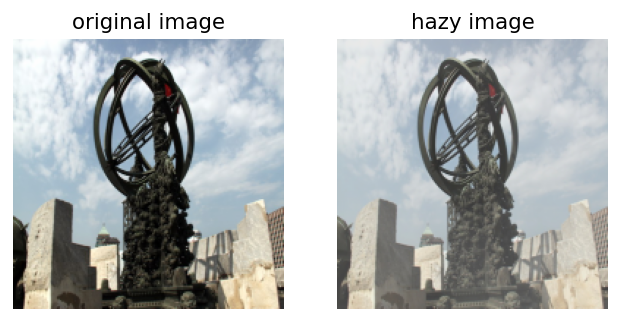

In [ ]:
print(imgs.shape)
im = imgs[25,:,:,:]
im_hazy = labels[25,:,:,:]
plt.figure(dpi=128)
plt.subplot(121)
plt.imshow(im)
plt.axis('off')
plt.title('original image')
plt.subplot(122)
plt.imshow(im_hazy)
plt.title('hazy image')
plt.axis('off')
plt.show()

In [ ]:
# callbacks = [
#     ModelCheckpoint("model.h5", save_best_only=True)
# ]
model.fit(labels,imgs,epochs=250,batch_size=10)

Epoch 1/250
6/6 [==============================] - 16s 3s/step - loss: 7.3439 - accuracy: 0.3533
Epoch 2/250
6/6 [==============================] - 16s 3s/step - loss: 7.3250 - accuracy: 0.3535
Epoch 3/250
6/6 [==============================] - 15s 3s/step - loss: 7.3051 - accuracy: 0.3536
Epoch 4/250
6/6 [==============================] - 15s 2s/step - loss: 7.2866 - accuracy: 0.3534
Epoch 5/250
6/6 [==============================] - 15s 3s/step - loss: 7.2670 - accuracy: 0.3533
Epoch 6/250
6/6 [==============================] - 15s 3s/step - loss: 7.2484 - accuracy: 0.3533
Epoch 7/250
6/6 [==============================] - 15s 3s/step - loss: 7.2298 - accuracy: 0.3536
Epoch 8/250
6/6 [==============================] - 15s 3s/step - loss: 7.2106 - accuracy: 0.3537
Epoch 9/250
6/6 [==============================] - 15s 3s/step - loss: 7.1916 - accuracy: 0.3532
Epoch 10/250
6/6 [==============================] - 15s 3s/step - loss: 7.1727 - accuracy: 0.3534
Epoch 11/250
6/6 [===========

(1, 185, 185, 3)


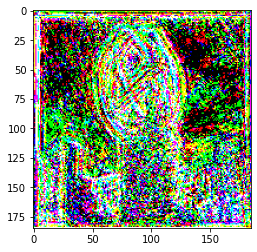

In [ ]:
inp = np.expand_dims(im_hazy,axis=0)
out = model.predict(inp)
print(out.shape)
out=np.uint8(np.squeeze(out[0,:,:,:]))
plt.imshow(out)

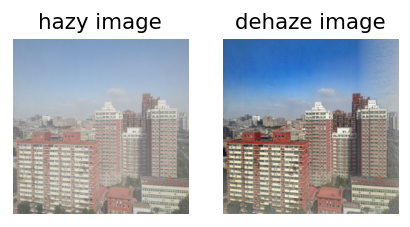

In [ ]:

im = plt.imread('/content/0001.png')
im_hazy = plt.imread('/content/outdoor/hazy/0001_0.8_0.2.jpg')
im_hazy = resize(im_hazy,(250,250))
plt.figure(dpi=128)
plt.subplot(131)
plt.imshow(im_hazy)
plt.axis('off')
plt.title('hazy image')
plt.subplot(132)
plt.imshow(im)
plt.title('dehaze image')
plt.axis('off')
plt.show()